# Tree of Thoughts

Yao 등이 제안한 [Tree of Thoughts](https://arxiv.org/abs/2305.10601) (ToT)는 반성/평가와 간단한 검색을 결합한 일반적인 LLM 에이전트 검색 알고리즘입니다 (이 경우 BFS를 사용하지만 원하는 경우 DFS 또는 다른 알고리즘을 적용할 수 있습니다).

![LATS diagram](./img/tot.png)

세 가지 주요 단계가 있습니다:

1. Expand: 문제에 대한 1개 이상의 후보 솔루션을 생성합니다.
2. Score: 응답의 품질을 측정합니다.
3. Prune: 상위 K개의 최고 후보를 유지합니다.

그런 다음 솔루션을 찾지 못한 경우(또는 솔루션의 품질이 불충분한 경우) "Expand"로 돌아갑니다.


## 전제 조건

튜토리얼의 종속 패키지를 설치하고 선택한 LLM 제공자에 대한 API 키를 설정합니다.

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
# 알고리즘을 시각화하기 위해
trace = True
if trace:
    _set_env("LANGSMITH_API_KEY")
    os.environ["LANGSMITH_PROJECT"] = "ToT Tutorial"

## 작업 정의

우리 에이전트는 "24 게임"을 플레이하려고 시도합니다. 4개의 숫자가 주어지면, 각 숫자를 정확히 한 번 사용하여 `24`로 평가되는 수학 방정식을 생성해야 합니다.

In [ ]:
import operator
from typing import List, Literal, Union, NamedTuple, Optional
from pydantic import BaseModel, Field

OperatorType = Literal["+", "-", "*", "/"]
TokenType = Union[float, OperatorType]

## 이러한 스키마를 사용하여 LLM에게 24로 평가되는 방정식을 생성하도록 프롬프트합니다.


class Equation(BaseModel):
    """제공된 숫자들을 결합하여 목표 24에 도달하는 공식."""

    tokens: List[TokenType] = Field(
        description="역 폴란드 표기법으로 표현된 토큰과 연산자의 스택. 예: [3, 4, '+', -1, '*']는 (3 + 4) * -1 = -7로 평가됩니다.",
    )

    def compute(self) -> float:
        op_funcs = {
            "+": operator.add,
            "-": operator.sub,
            "*": operator.mul,
            "/": operator.truediv,
        }
        stack = []
        for token in self.tokens:
            if isinstance(token, float):
                stack.append(token)
            else:
                b, a = stack.pop(), stack.pop()
                stack.append(op_funcs[token](a, b))

        return stack[0]


class GuessEquations(BaseModel):
    """여러 방정식을 추측으로 제출합니다."""

    reasoning: str = Field(
        description="제출된 추측 뒤에 있는 추론. 이러한 방정식에 어떻게 도달했는지 설명하십시오."
    )

    equations: List[Equation] = Field(
        description="추측으로 제출할 방정식 목록."
    )


## 이러한 객체는 에이전트 상태 내의 단일 "후보"(또는 점수가 매겨진 후보)를 나타냅니다.
# 자신의 작업에 맞게 후보 객체를 업데이트할 수 있습니다.


class Candidate(NamedTuple):
    candidate: Equation
    score: Optional[float] = None
    feedback: Optional[str] = None

    def __str__(self):
        try:
            computed = self.candidate.compute()
        except Exception as e:
            computed = f"Invalid equation: {self.candidate.tokens}; Error: {repr(e)}"

        return f"Equation({self.candidate.tokens}) = {computed} (Reward: {self.score})"


class ScoredCandidate(Candidate):
    candidate: Equation
    score: float
    feedback: str

#### 데이터 가져오기

[Game of 24](https://github.com/princeton-nlp/tree-of-thought-llm) 데이터셋의 예제를 사용합니다.

In [ ]:
import requests
import csv

csv_data = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/game-of-24/24.csv"
).content.decode("utf-8")
# Puzzles 열만 가져오기 (열 인덱스 1)
puzzles = [row[1].strip() for row in csv.reader(csv_data.splitlines()[1:])]

print(f"Example puzzles: {puzzles[:3]}")

## Expander

"tree of thoughts" 알고리즘은 비교적 일반적입니다. 주요 두 가지 작업별 구성 요소는 **expander**와 **scorer**입니다.
Expander (증강된 LLM)는 문제에 대한 1개 이상의 솔루션을 생성하려고 시도합니다. 후속 시도에서는 이전 검색의 시드/후보 값이 제공됩니다.

자신의 작업 요구 사항에 맞게 이 섹션을 업데이트할 수 있습니다. Expander는 임의로 복잡할 수 있습니다. 필요한 것은 문제와 선택적 이전 시도(또는 시도들)를 받아들이고 새로운 결과를 반환하는 것뿐입니다.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are playing the Game of 24. Using the provide numbers, create an equation that evaluates to 24.\n"
            "Submit exactly {k} guesses for this round.",
        ),
        ("user", "Solve the 24 game for these numbers: {problem}.{candidate}"),
    ],
).partial(candidate="")
llm = ChatOpenAI(model="gpt-4o-mini")

bound_llm = llm.with_structured_output(GuessEquations)
solver = prompt | bound_llm

# Scorer

이 게임에서 scorer는 간단합니다. 두 가지를 확인해야 합니다:

1. LLM이 각 숫자를 정확히 한 번 사용하여 유효한 방정식을 생성했는지 확인합니다.
2. 방정식이 24로 평가되는지 확인합니다.

자신의 작업 요구 사항에 맞게 이 함수를 업데이트할 수 있습니다.

In [ ]:
def compute_score(problem: str, candidate: Candidate) -> ScoredCandidate:
    numbers = list(map(int, problem.split()))
    # 후보 방정식이 4개의 숫자를 모두 정확히 한 번 사용하는지 확인
    used_numbers = [
        token for token in candidate.candidate.tokens if isinstance(token, float)
    ]
    if sorted(used_numbers) != sorted(numbers):
        score = 0
        feedback = "The equation must use all 4 numbers exactly once."
        return ScoredCandidate(
            candidate=candidate.candidate, score=score, feedback=feedback
        )
    try:
        result = candidate.candidate.compute()
        score = 1 / (1 + abs(24 - result))
        feedback = f"Result: {result}"
    except Exception as e:
        score = 0
        feedback = f"Invalid equation. Error: {repr(e)}"
    return ScoredCandidate(
        candidate=candidate.candidate, score=score, feedback=feedback
    )

## 그래프

이제 그래프를 만들 시간입니다.

In [ ]:
import operator
from typing import Optional, Dict, Any
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph
from langgraph.runtime import Runtime

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Send


def update_candidates(
    existing: Optional[list] = None,
    updates: Optional[Union[list, Literal["clear"]]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == "clear":
        return []
    # 리스트 연결
    return existing + updates


class ToTState(TypedDict):
    problem: str
    candidates: Annotated[List[Candidate], update_candidates]
    scored_candidates: Annotated[List[ScoredCandidate], update_candidates]
    depth: Annotated[int, operator.add]


class Context(TypedDict, total=False):
    max_depth: int
    threshold: float
    k: int
    beam_size: int


class EnsuredContext(TypedDict):
    max_depth: int
    threshold: float
    k: int
    beam_size: int


def _ensure_context(ctx: Context) -> EnsuredContext:
    """검색 알고리즘을 구성하는 매개변수를 가져옵니다."""
    return {
        "max_depth": ctx.get("max_depth", 10),
        "threshold": ctx.get("threshold", 0.9),
        "k": ctx.get("k", 5),
        "beam_size": ctx.get("beam_size", 3),
    }


class ExpansionState(ToTState):
    seed: Optional[Candidate]


def expand(
    state: ExpansionState, *, runtime: Runtime[Context]
) -> Dict[str, List[Candidate]]:
    """다음 상태를 생성합니다."""
    ctx = _ensure_context(runtime.context)
    if not state.get("seed"):
        candidate_str = ""
    else:
        candidate_str = "\n\n" + str(state["seed"])
    try:
        equation_submission = solver.invoke(
            {
                "problem": state["problem"],
                "candidate": candidate_str,
                "k": ctx["k"],
            },
        )
    except Exception:
        return {"candidates": []}
    new_candidates = [
        Candidate(candidate=equation) for equation in equation_submission.equations
    ]
    return {"candidates": new_candidates}


def score(state: ToTState) -> Dict[str, Any]:
    """후보 생성을 평가합니다."""
    candidates = state["candidates"]
    scored = []
    for candidate in candidates:
        scored.append(compute_score(state["problem"], candidate))
    return {"scored_candidates": scored, "candidates": "clear"}


def prune(state: ToTState, *, runtime: Runtime[Context]) -> Dict[str, Any]:
    scored_candidates = state["scored_candidates"]
    beam_size = _ensure_context(runtime.context)["beam_size"]
    organized = sorted(
        scored_candidates, key=lambda candidate: candidate[1], reverse=True
    )
    pruned = organized[:beam_size]
    return {
        # 다음 반복의 시작점 업데이트
        "candidates": pruned,
        # 이전 메모리 지우기
        "scored_candidates": "clear",
        # 깊이를 1씩 증가
        "depth": 1,
    }


def should_terminate(
    state: ToTState, runtime: Runtime[Context]
) -> Union[Literal["__end__"], Send]:
    ctx = _ensure_context(runtime.context)
    solved = state["candidates"][0].score >= ctx["threshold"]
    if solved or state["depth"] >= ctx["max_depth"]:
        return "__end__"
    return [
        Send("expand", {**state, "somevalseed": candidate})
        for candidate in state["candidates"]
    ]


# 그래프 생성
builder = StateGraph(state_schema=ToTState, context_schema=Context)

# 노드 추가
builder.add_node(expand)
builder.add_node(score)
builder.add_node(prune)

# 엣지 추가
builder.add_edge("expand", "score")
builder.add_edge("score", "prune")
builder.add_conditional_edges("prune", should_terminate, path_map=["expand", "__end__"])

# 진입점 설정
builder.add_edge("__start__", "expand")

# 그래프 컴파일
graph = builder.compile(checkpointer=InMemorySaver())

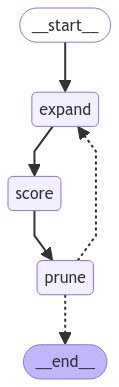

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 실행

이제 퍼즐 중 하나에서 시도해 봅시다!

In [10]:
for step in graph.stream(
    {"problem": puzzles[42]},
    config={"configurable": {"thread_id": "test_1"}},
    context={"depth": 10},
):
    print(step)

{'expand': {'candidates': [Candidate(candidate=Equation(tokens=[12.0, 5.0, '/', 7.0, '*']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, 1.0, '+', 5.0, '*']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, 7.0, '*', 1.0, '/']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[5.0, 7.0, '*', 1.0, '*']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[7.0, 5.0, '*', 12.0, '/']), score=None, feedback=None)]}}
{'score': {'candidates': 'clear', 'scored_candidates': [ScoredCandidate(candidate=Equation(tokens=[12.0, 5.0, '/', 7.0, '*']), score=0, feedback='The equation must use all 4 numbers exactly once.'), ScoredCandidate(candidate=Equation(tokens=[12.0, 1.0, '+', 5.0, '*']), score=0, feedback='The equation must use all 4 numbers exactly once.'), ScoredCandidate(candidate=Equation(tokens=[12.0, 7.0, '*', 1.0, '/']), score=0, feedback='The equation must use all 4 numbers exactly once.'), ScoredCandidate(candid

In [ ]:
final_state = graph.get_state({"configurable": {"thread_id": "test_1"}})
winning_solution = final_state.values["candidates"][0]
search_depth = final_state.values["depth"]
if winning_solution[1] == 1:
    print(f"Found a winning solution in {search_depth} steps: {winning_solution}")
else:
    print(
        f"Failed to find a winning solution in {search_depth} steps. Best guess: {winning_solution}"
    )